Visual sanity checks for collocated Sentinel-1 / Sentinel-2 scenes.

This notebook is for inspection only.
It is NOT used for dataset construction or model training.

All paths are read from the collocation manifest CSV produced by build_manifest.py.

Also, later it performs visual sanity check for S1 → S2 patch pairs.

In [3]:
import os
import math
import ast

import numpy as np
import pandas as pd
import rasterio
from rasterio.enums import Resampling

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def read_band(path, scale=None):
    """
    Read a raster band with optional downsampling.
    """
    with rasterio.open(path) as src:
        if scale is not None and scale < 1.0:
            out_h = max(1, math.ceil(src.height * scale))
            out_w = max(1, math.ceil(src.width * scale))
            out_shape = (1, out_h, out_w)
            data = src.read(
                1,
                out_shape=out_shape,
                resampling=Resampling.bilinear,
            ).astype("float32")
        else:
            data = src.read(1).astype("float32")
    return data


def scale_percentile(arr, lower=2, upper=98):
    """
    Percentile-based contrast stretching for visualisation.
    """
    valid = arr[~np.isnan(arr)]
    if valid.size == 0:
        return np.zeros_like(arr)

    lo = np.percentile(valid, lower)
    hi = np.percentile(valid, upper)

    if hi <= lo:
        return np.clip(arr, 0, 1)

    scaled = (arr - lo) / (hi - lo)
    return np.clip(scaled, 0, 1)


In [3]:
def make_composite(b2, b3, b4, gamma=1.2):
    """
    Create a true-colour Sentinel-2 composite (B4, B3, B2).
    """
    r = scale_percentile(b4)
    g = scale_percentile(b3)
    b = scale_percentile(b2)

    rgb = np.stack([r, g, b], axis=-1)

    if gamma != 1.0:
        rgb = np.power(rgb, 1.0 / gamma)

    rgb = np.clip(rgb, 0, 1)
    return (rgb * 255).astype(np.uint8)


In [4]:
def make_thumbnail(row, downsample_factor=8, gamma=1.2):
    """
    Create visual thumbnails for one manifest row.

    For visualisation, the first available collocated folder is used.
    """
    mpf_path = row["file"]
    basename = os.path.splitext(os.path.basename(mpf_path))[0]

    collocated_folders = row["collocated_folders"]
    if not collocated_folders:
        return basename, None, None, None

    collocated_folder = collocated_folders[0]

    # Sentinel-2 bands
    b2p = os.path.join(collocated_folder, "B2.img")
    b3p = os.path.join(collocated_folder, "B3.img")
    b4p = os.path.join(collocated_folder, "B4.img")

    # Sentinel-1 bands
    hh_path = os.path.join(collocated_folder, "Sigma0_HH_db_corr028_m.img")
    hv_path = os.path.join(collocated_folder, "Sigma0_HV_db_corr024_m.img")

    for p in (b2p, b3p, b4p, hh_path, hv_path):
        if not os.path.exists(p):
            return basename, None, None, None

    scale = 1.0 / downsample_factor

    try:
        b2 = read_band(b2p, scale=scale)
        b3 = read_band(b3p, scale=scale)
        b4 = read_band(b4p, scale=scale)
        hh = read_band(hh_path, scale=scale)
        hv = read_band(hv_path, scale=scale)
    except Exception:
        return basename, None, None, None

    rgb = make_composite(b2, b3, b4, gamma=gamma)
    hh_scaled = scale_percentile(hh)
    hv_scaled = scale_percentile(hv)

    return basename, rgb, hh_scaled, hv_scaled


In [5]:
csv_path = "artifacts/selected_data_with_all_collocated_paths.csv"
df = pd.read_csv(csv_path)

# Convert string representation of lists back to Python lists
df["collocated_folders"] = df["collocated_folders"].apply(ast.literal_eval)

print(f"Loaded {len(df)} manifest entries")
df.head()

Loaded 1 manifest entries


,Unnamed: 0,file,date,time,sza,zone,clouds,mpf_min,mpf_max,mpf_mean,mpf_std,mpf_pixels,mpf_area_km2,s2_id,collocated_folders
0,54,/home/wch/MPF_Navirah/processed_mpf_collocated...,2023-06-30,174911,49.478018,17N,1.0,0.0,1.0,0.210426,0.350962,43150341,4315.0341,S2A_MSIL1C_20230630T174911_N0510_R141_T17XNA_2...,[/cpnet/li3_cpdata/SATS/COLOCATION_S1_S2/aa533...


In [6]:
records = []

for i, row in df.iterrows():
    basename, rgb, hh, hv = make_thumbnail(
        row,
        downsample_factor=8,
        gamma=1.2,
    )

    records.append({
        "basename": basename,
        "rgb": rgb,
        "hh": hh,
        "hv": hv,
        "index": i,
    })

print(f"Prepared {len(records)} records for visualisation")


Prepared 1 records for visualisation


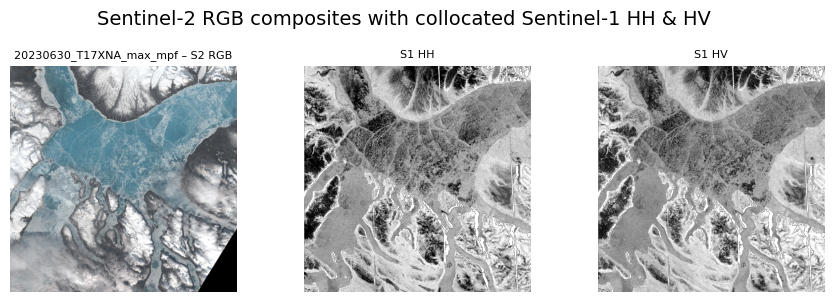

In [7]:
cols = 3   # S2 RGB, S1 HH, S1 HV
nrows = len(records)

fig = plt.figure(figsize=(cols * 3.5, nrows * 3.5))
gs = gridspec.GridSpec(nrows, cols, wspace=0.3, hspace=0.3)

for idx, rec in enumerate(records):
    if rec["rgb"] is None:
        continue

    # Sentinel-2 RGB
    ax1 = fig.add_subplot(gs[idx, 0])
    ax1.imshow(rec["rgb"])
    ax1.set_title(f"{rec['basename']} – S2 RGB", fontsize=8)
    ax1.axis("off")

    # Sentinel-1 HH
    ax2 = fig.add_subplot(gs[idx, 1])
    ax2.imshow(rec["hh"], cmap="gray")
    ax2.set_title("S1 HH", fontsize=8)
    ax2.axis("off")

    # Sentinel-1 HV
    ax3 = fig.add_subplot(gs[idx, 2])
    ax3.imshow(rec["hv"], cmap="gray")
    ax3.set_title("S1 HV", fontsize=8)
    ax3.axis("off")

plt.suptitle(
    "Sentinel-2 RGB composites with collocated Sentinel-1 HH & HV",
    fontsize=14,
)
plt.show()


Visual sanity check for S1 → S2 patch pairs.

visualizes:
- Sentinel-1 HH and HV patches
- Corresponding Sentinel-2 RGB patches (B4, B3, B2)

No preprocessing, filtering, or model logic is applied.


In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt


In [9]:
def normalize_rgb(rgb, lower=2, upper=98):
    """
    Percentile-based normalization for RGB visualization.

    :param rgb: [H, W, 3] array
    :return: [H, W, 3] array in [0, 1]
    """
    out = np.zeros_like(rgb, dtype=np.float32)

    for i in range(3):
        band = rgb[..., i]
        lo, hi = np.percentile(band, lower), np.percentile(band, upper)
        band = np.clip(band, lo, hi)
        out[..., i] = (band - lo) / (hi - lo + 1e-6)

    return out


In [16]:
def visualize_random_patches(
    s1_patches,
    s2_patches,
    num_patches=5,
    seed=42,
):
    """
    Visualize random S1–S2 patch pairs.

    :param s1_patches: [N, 2, H, W] (HH, HV)
    :param s2_patches: [N, 4, H, W] (B2, B3, B4, B8)
    """
    random.seed(seed)
    idxs = random.sample(
        range(len(s1_patches)),
        min(num_patches, len(s1_patches)),
    )

    for idx in idxs:
        hh = s1_patches[idx, 0]
        hv = s1_patches[idx, 1]

        # S2 RGB = B4, B3, B2
        b2, b3, b4 = s2_patches[idx, 0], s2_patches[idx, 1], s2_patches[idx, 2]
        rgb = np.stack([b4, b3, b2], axis=-1)
        rgb = normalize_rgb(rgb)

        plt.figure(figsize=(12, 4))

        # --- S1 HH ---
        plt.subplot(1, 3, 1)
        plt.title(f"S1 HH\n{hh.shape}")
        plt.imshow(hh, cmap="gray")
        plt.axis("off")

        # --- S1 HV ---
        plt.subplot(1, 3, 2)
        plt.title(f"S1 HV\n{hv.shape}")
        plt.imshow(hv, cmap="gray")
        plt.axis("off")

        # --- S2 RGB ---
        plt.subplot(1, 3, 3)
        plt.title(f"S2 RGB\n{rgb.shape}")
        plt.imshow(rgb)
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [14]:
data = np.load("/home/nkamal/projects/colocation/new_colocation/colocation_code/data_processing/patching/patch_dataset.npz")
s1_patches = data["s1"]
s2_patches = data["s2"]

print(s1_patches.shape, s2_patches.shape)


(3107, 2, 256, 256) (3107, 4, 256, 256)


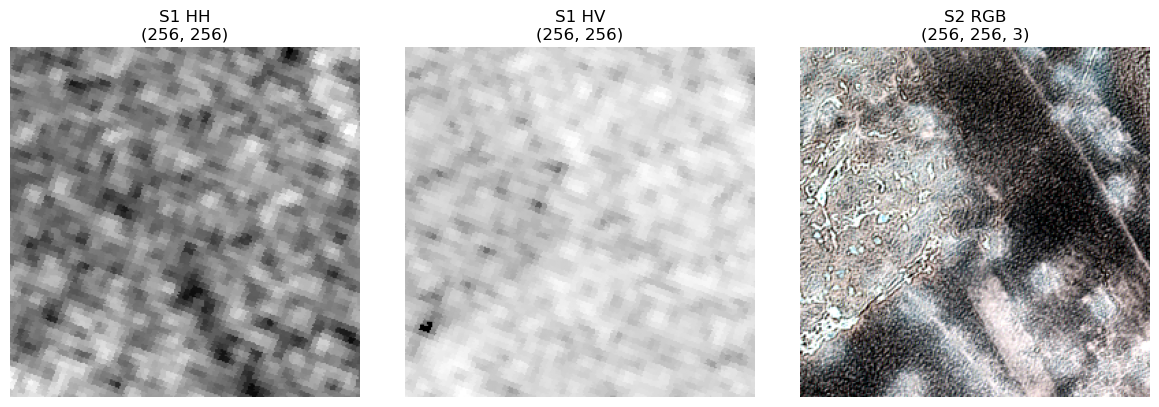

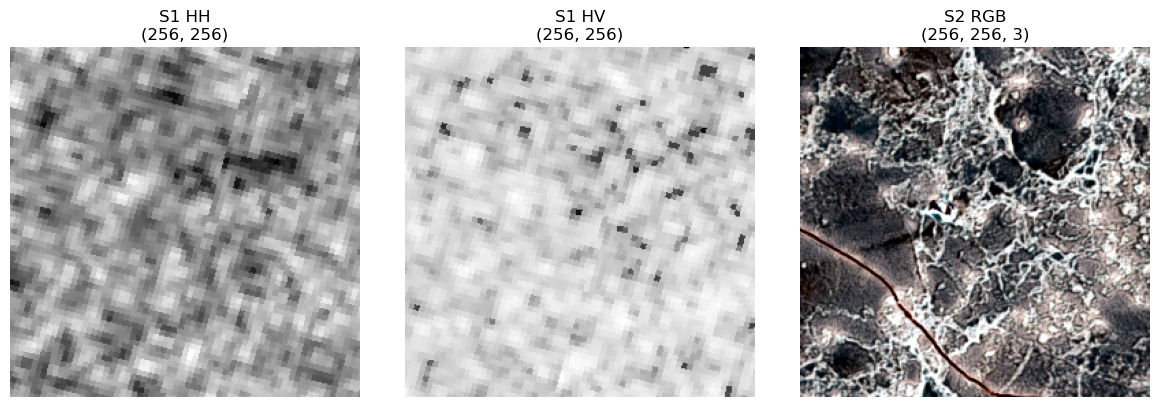

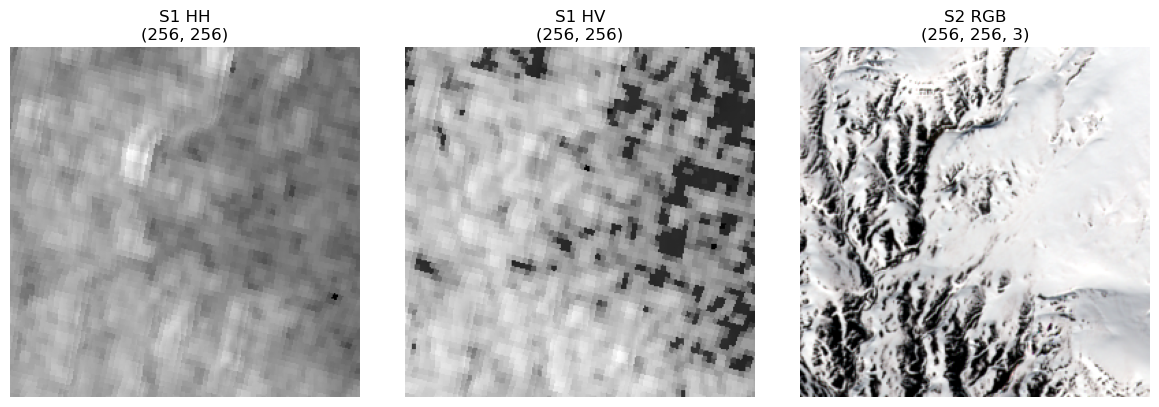

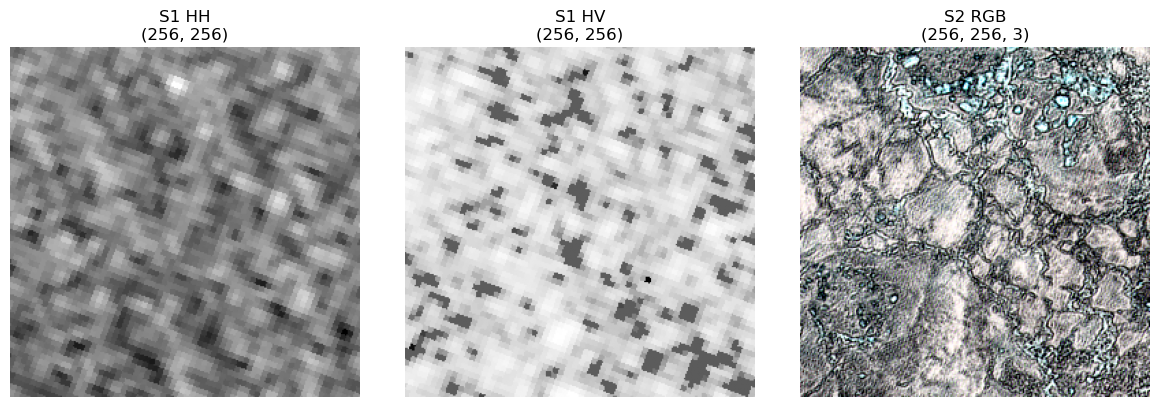

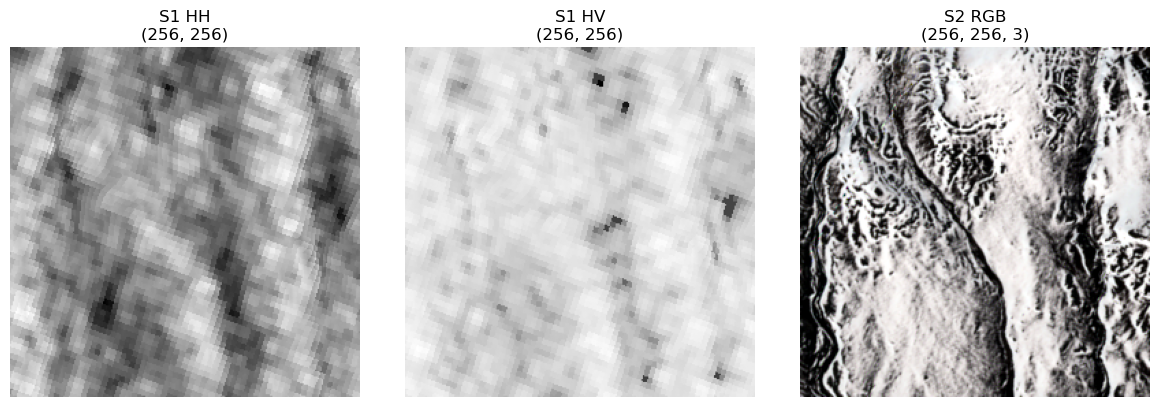

In [22]:
visualize_random_patches(
    s1_patches,
    s2_patches,
    num_patches=5,
)
